# Projet RAG LO17 Guide de Voyage


## Initialisation

In [ ]:
%pip install -U --quiet langchain-chroma

In [ ]:
!pip install langchain-core langchain langchain-google-genai -U langchain-community chromadb

In [ ]:
# Importation des bibliothèques standard
import os
import pickle

# Importation des bibliothèques Colab
from google.colab import drive, userdata

# Importation des composants LangChain
from langchain import PromptTemplate
from langchain.docstore.document import Document
from langchain.document_loaders import WebBaseLoader
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

# Importation des intégrations Google Generative AI
from langchain_google_genai import (
    GoogleGenerativeAIEmbeddings,
    ChatGoogleGenerativeAI
)

In [ ]:
# 2. Pour remonter
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration de la cle API


In [ ]:
GOOGLE_API_KEY=userdata.get('lo17')

os.environ["lo17"] = GOOGLE_API_KEY

In [ ]:
GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## RAG


In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import Chroma
from langchain.chains import StuffDocumentsChain, LLMChain, ConversationalRetrievalChain
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

#GOOGLE_API_KEY = os.environ["lo17"]
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

### Création du RAG ###
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)

vectorstore_disk = Chroma(
                        persist_directory="/content/drive/MyDrive/LO17 - projet 2/chroma_db",       # Directory of db
                        embedding_function=gemini_embeddings   # Embedding model
                   )
# Initialisation du LLM Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=GOOGLE_API_KEY,
    temperature=0.3
)

# Utilisation du vectorstore_disk précédemment défini
retriever = vectorstore_disk.as_retriever(search_kwargs={"k": 5})

# Mémoire pour gérer l’historique de la conversation
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True  # Important pour Gemini
)

# Prompt précis pour le comportement du modèle
prompt = PromptTemplate.from_template("""
Tu es un guide touristique expert. Ta tâche est de répondre à la question de l'utilisateur en t'appuyant uniquement sur les informations fournies dans le contexte.

Règles à respecter :
- Ne fais aucune inférence ou supposition. Reste strictement dans le cadre du contexte.
- N’ajoute aucun contenu promotionnel, suggestion, ou lien externe non mentionné explicitement.
- Si l'information n’est pas disponible dans le contexte, réponds clairement : "Je ne sais pas."
- Rédige une réponse claire, et directement utile.

Format :
- Réponds de manière professionnelle.
- Évite les formules vagues ou incertaines.
- Si plusieurs lieux ou options sont possibles, liste-les.
- Réponds si possible dans un format structuré (liste à points par exemple)
- A la fin de ta réponse, propose des liens utiles qui seront uniquement les sources (URL) des données que tu utilises.

Question : {question}
Contexte : {context}
Réponse :
""")

# Stuff chain
document_prompt = PromptTemplate(
    input_variables=["page_content", "source"],
    template="{page_content}\n(Source: {source})"
)

# llm_chain pour combiner les docs (contexte)
llm_chain_for_docs = LLMChain(
    llm=llm,
    prompt=prompt
)

stuff_chain = StuffDocumentsChain(
    llm_chain=llm_chain_for_docs,
    document_prompt=document_prompt,
    document_variable_name="context"
)

prompt_q_generator = PromptTemplate.from_template("""
Étant donné la conversation et la question suivante, reformule la question pour qu'elle soit une question autonome.
Si la question te semble déjà autonome, laisse là ainsi.
Donne directement une seule reformulation.
Conversation précédente : {chat_history}
Question de suivi : {question}
Question autonome :
""")
question_generator = LLMChain(llm=llm, prompt=prompt_q_generator)

# Création de la ConversationalRetrievalChain
qa_chain = ConversationalRetrievalChain(
    retriever=retriever,
    combine_docs_chain=stuff_chain,
    question_generator=question_generator,
    memory=memory
)

In [ ]:
query = "est il safe de se rendre au yemen ?"
docs_with_scores = vectorstore_disk.similarity_search_with_score(query, k=5)

for doc, score in docs_with_scores:
    print(f"Score: {score}")
    print(f"Document: {doc.page_content}")
    print("---")

Score: 0.5838077068328857
Document: 






Yémen - Ministère de l’Europe et des Affaires étrangères

























































Aller au menu
Aller au menu mobile
Aller au contenu





France Diplomatie

Ouvrir le menu







Emplois et concoursEmplois et concours

Salle de  presseSalle de  presse

Archives et bibliothèqueArchives et bibliothèque

FALC

Malentendants ? Sourds ? Contactez-nous avec ACCEO



Choisissez votre langue


								عربي
								

								Deutsch
								

								English
								

								Español
								

								Français
								

								Русский
								







Le ministère


Fermer le menu 'Le ministère'


Le ministère


Les ministres


Les missions du ministère de l’Europe et des Affaires étrangères


Les métiers de la diplomatie


La diversité au ministère


L’égalité femmes - hommes au ministère


Le Quai d’Orsay s’engage pour la jeunesse


Plan de transformation numérique du ministère


L’Académie diplomatique et consulaire


In [ ]:
user_input = "Que manger à Tokyo ?"
qa_chain.invoke({"question": user_input})["answer"]

"À Tokyo, vous aurez l'embarras du choix pour déjeuner ou dîner, avec environ 150 000 restaurants. Des immeubles entiers proposent des restaurants à quasi tous les étages. Voici quelques options :\n\n*   **Plats factices :** À l’entrée des restaurants, vous trouverez des plats factices moulés dans la cire et peints, ce qui est pratique pour savoir ce qui est proposé et passer votre commande.\n*   **Tabehôdai et nomihôdai :** Il existe de nombreux restaurants où vous pouvez manger (tabehôdai) ou boire (nomihôdai) à volonté.\n*   **Azabu-Juban :** Le quartier propose une variété de magasins et de restaurants.\n*   **Maid cafés à Akihabara :** Vous pouvez visiter les maid cafés, aux décors de poupées et aux couleurs acidulées.\n\nLiens utiles:\n\n*   [https://www.routard.com/fr/guide/a/gastronomie-ou-manger/asie/japon/tokyo](https://www.routard.com/fr/guide/a/gastronomie-ou-manger/asie/japon/tokyo)"

In [ ]:
user_input = "Et à Naples ?"
qa_chain.invoke({"question": user_input})["answer"]

"Les spécialités culinaires de Naples sont :\n\n*   **Pizza:** La pizza napolitaine est protégée par le label « spécialité traditionnelle garantie ». Les authentiques pizze napolitaines sont la margherita et la marina extra. Il existe d'autres spécialités comme la pizza fritta, la pizza friarielli, celle aux légumes grillés et celle roquette-bocconcini di mozzarella frais.\n*   **Poisson et fruits de mer:** Les plats sont à base d’ail, de citron et de poivre. On trouve des seiches, des soupes de poisson, des poulpes, des palourdes (vongole) et des moules (cozze). Il faut goûter au baccalà alla partenopea.\n*   **Viande:** L'agneau ou le porc sont plus courants que la viande bovine. On retrouve la viande de veau préparée au four, en paupiettes, en boulettes ou en brochettes, et également dans l’incontournable ragù. Le foie (fegato), les tripes (trippa), les côtes de porc (cotoletta ou braciola), le lapin (coniglio), le lièvre (lepre) apparaissent souvent sur les cartes.\n*   **Fromages 

In [ ]:
# Detecteur d'hallucination par mot clé
# Mots ou expressions suspectes d'hallucination
suspect_keywords = [
    "je pense que", "je crois que", "il semble que", "il est probable que", "il paraît que",
    "probablement", "peut-être", "possiblement", "j'imagine que", "il est possible que",
    "il pourrait être", "cela pourrait être", "on peut supposer", "selon moi",
    "à mon avis", "je dirais que", "je suppose que", "on peut dire que", "on pourrait penser que",
    "il est concevable que", "potentiellement", "en théorie", "cela laisse penser que",
    "cela implique que", "il est plausible que", "il est envisageable que",
    "cela pourrait signifier", "cela peut signifier",
    "on peut envisager", "dans certains cas", "souvent", "parfois", "généralement",
    "habituellement", "fréquemment", "il est courant que", "certains estiment que",
    "des études montrent que", "les experts pensent que", "on estime que", "il est reconnu que"
]

def detect_hallucination(response, keywords):
    response_lower = response.lower()
    return any(keyword in response_lower for keyword in keywords)


hallucinations = [detect_hallucination(r, suspect_keywords) for r in generated_clean]
nb_hallu = sum(hallucinations)
total = len(hallucinations)
print(f" Réponses suspectes (hallucinations possibles) : {nb_hallu}/{total} → {nb_hallu/total:.2%}")

# Affichage des ex suspects
for i, flag in enumerate(hallucinations):
    if flag:
        print(f"\n Réponse {i+1} potentiellement hallucinée :\n{generated_clean[i]}")


##Ameliorations
### 1. Limites du RAG de base

Un système RAG (Retrieval-Augmented Generation) standard présente plusieurs limites :

- Les documents récupérés peuvent être peu pertinents si la similarité sémantique est mal exploitée.
- Le modèle de génération peut "halluciner", c’est-à-dire inventer des informations non présentes dans les documents.
- L’absence d’historique empêche un enchaînement fluide des questions/réponses dans un dialogue.
- Le format des réponses peut être non structuré ou peu adapté à l’utilisateur cible.

### 2. Améliorations implémentées

####  Prompt Engineering
> Le prompt est la clé du contrôle du comportement du modèle génératif. Dans ce projet, un prompt structuré et contraignant a été élaboré afin de :

- **définir un rôle clair** pour le modèle (ex. "guide touristique expert"),
- **interdire les généralisations**, suggestions, ou contenus non présents dans les documents sources,
- **encourager la concision**, la clarté et l'objectivité dans la réponse,
- **imposer une citation des sources**, pour renforcer la traçabilité et la fiabilité des réponses.

**Extrait de prompt utilisé :**

Tu es un guide touristique expert. Ta tâche est de répondre uniquement en utilisant les informations suivantes...
Ne fais pas d'inférences ni de généralisations non basées sur ces informations...
Inclut des sources exactes quand cela est possible...

#### Vérifiabilité et transparence
> Les réponses sont accompagnées de leurs sources exactes. L’utilisateur peut ainsi vérifier les informations fournies et gagner en confiance.


####  Mémoire de conversation
> L’introduction d’une mémoire conversationnelle permet de conserver le contexte des échanges successifs. Cela est particulièrement utile dans les cas d’usage interactifs (ex : tourisme, assistant pédagogique).

##Evaluation du RAG

In [ ]:
# ragas
!pip install ragas datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
data = [
    {
        "question": "Quels vaccins sont recommandés pour un voyage en Thaïlande ?",
        "reference_answer": (
            "Selon diplomatie.gouv.fr, aucun vaccin n’est obligatoire, "
            "mais il est recommandé d’être à jour des vaccinations universelles : "
            "DTP (diphtérie‑tétanos‑poliomyélite), ROR (rougeole‑oreillons‑rubéole), "
            "et éventuellement tuberculose ; le vaccin contre la grippe peut également être conseillé "
            "Wikivoyage recommande aussi DTP et ROR comme de base pour toute Asie du Sud‑Est (cf. page Santé)."
        )
    },
    {
        "question": "Propose moi un itinéraire à Lisbonne",
        "reference_answer": (
            "D’après Wikivoyage, un itinéraire de 2‑3 jours peut inclure : "
            "- Quartier de Belém (tour de Belém, monastère des Hiéronymites) accessible en train ou tram 15E/bus 728 ; "
            "- Alfama via tram 12E/28E, se perdre dans ses ruelles, château São Jorge ; "
            "- Baixa, Chiado, Bairro Alto pour culture, cafés, vues panoramiques. "
        )
    },
    {
        "question": "Que faire à Tokyo",
        "reference_answer": (
            "Synthèse basé sur Wikivoyage & GoTokyo : "
            "- Découvrir quartiers variés : Asakusa (temple Senso‑ji), Shibuya, Shinjuku, Harajuku. "
            "- Sites célèbres : Palais impérial, temple Meiji Jingu, tour de Tokyo, Musée national d’Ueno. "
            "- Nature & excursions : hanami, Mont Takao, îles Izu/Ogasawara. "
        )
    },
    {
        "question": "Quels sont les plats typiques de Naples ?",
        "reference_answer": (
            "D’après Wikivoyage & wiki cuisine napolitaine & Carnival Cruise : "
            "- Pizza napolitaine (Margherita, fritta), sfogliatella, spaghetti allo scoglio/vongole. "
            "- Spécialités : ragù, polpette, parmigiana di melanzane, baba au rhum, spaghetti alla puttanesca. "
        )
    },
    {
        "question": "Quel est le climat en Albanie?",
        "reference_answer": (
            "Selon Wikivoyage & Wikipedia : "
            "- Climat méditerranéen sur les côtes (Adriatique, Ionienne), continental/montagnard dans l’intérieur. "
            "- Variations nord‑sud, hivers frais, sommets jusqu’à −10 °C en hiver. "
        )
    },
    {
        "question": "Les plus beaux quartiers de Buenos aires",
        "reference_answer": (
            "Synthèse Le Routard & Coeur de nomade & Tripadvisor : "
            "- Palermo (Soho, Hollywood) : bobo, animations, cafés, boutiques. "
            "- Recoleta : élégant, cimetière historique, musées (Bellamás Arts). "
            "- San Telmo : charme colonial, bars anciens, marché. "
            "- Puerto Madero : moderne, bord de fleuve. "
            "- La Boca pour ses couleurs vives et tango. "
        )
    }
]

dataset = Dataset.from_list(data)


In [ ]:
answers = []
contexts = []

for q in dataset["question"]:
    result = qa_chain.invoke({"question": q})
    answers.append(result["answer"])
    docs = retriever.get_relevant_documents(q)
    contexts.append([doc.page_content for doc in docs])

dataset = dataset.add_column("answer", answers)
dataset = dataset.add_column("contexts", contexts)


/tmp/ipython-input-13-1642921754.py:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(q)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

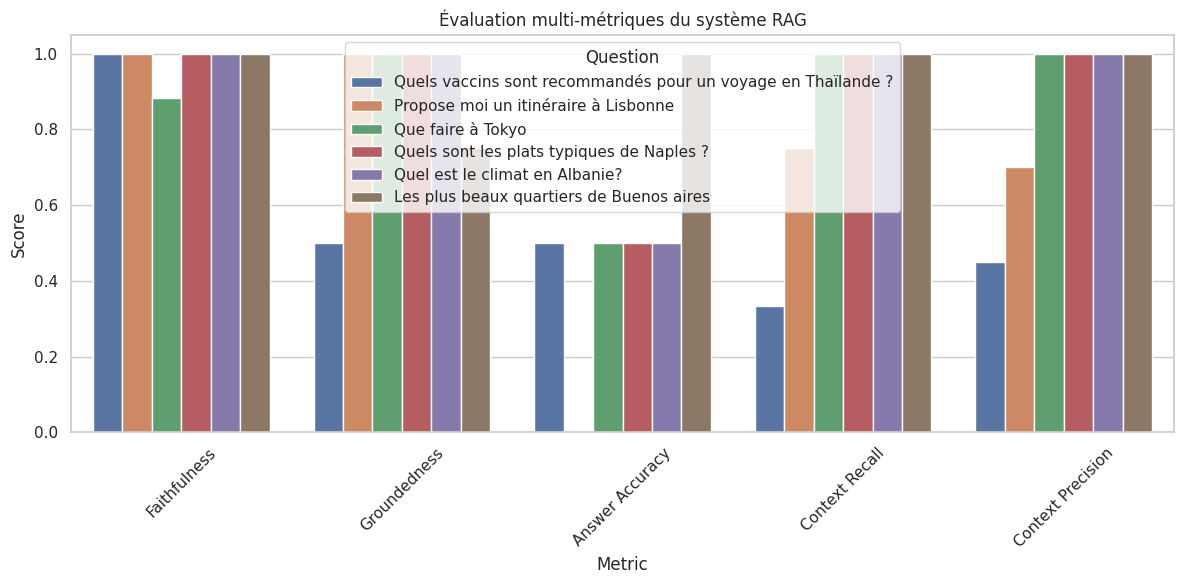

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
from ragas.llms import LangchainLLMWrapper
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import (
    AnswerAccuracy,
    ContextRelevance,
    ResponseGroundedness,
    ContextPrecision,
    ContextRecall,
    Faithfulness,
    ResponseRelevancy,
    AnswerCorrectness
)

import logging

# Configuration du logging
logging.basicConfig(
    filename='debug.log',  # Les logs seront écrits dans ce fichier
    level=logging.WARNING,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# (optionnel) Pour désactiver l'affichage dans la console aussi :
logging.getLogger("langchain_google_genai.chat_models").setLevel(logging.ERROR)
logging.getLogger("ragas.metrics._nv_metrics").setLevel(logging.ERROR)

# Mapping du dataset
samples = dataset.map(lambda x: {
    "question": x["question"],
    "answer": x["answer"],
    "ground_truth": x["reference_answer"],
    "contexts": x["contexts"]
}).to_list()

ragas_samples = [
    SingleTurnSample(
        user_input=s["question"],
        response=s["answer"],
        reference=s["ground_truth"],
        retrieved_contexts=s["contexts"]
    )
    for s in samples
]

evaluator_llm = LangchainLLMWrapper(llm)

metrics = {
    "Faithfulness": Faithfulness(llm=evaluator_llm),
    "Groundedness": ResponseGroundedness(llm=evaluator_llm),
    "Answer Accuracy": AnswerAccuracy(llm=evaluator_llm),
    "Context Recall": ContextRecall(llm=evaluator_llm),
    "Context Precision": ContextPrecision(llm=evaluator_llm)
}

# Évaluation avec gestion du quota
async def run_all_metrics():
    results = []
    request_count = 0
    start_time = time.time()

    for sample in ragas_samples:
        row = {"Question": sample.user_input}
        for name, metric in metrics.items():
            try:
                # Gestion du quota (15 requêtes par minute)
                if request_count >= 14:
                    elapsed = time.time() - start_time
                    if elapsed < 60:
                        wait_time = 60 - elapsed
                        print(f"[Quota] Attente de {int(wait_time)} secondes pour respecter la limite...")
                        await asyncio.sleep(wait_time)
                    request_count = 0
                    start_time = time.time()

                score = await metric.single_turn_ascore(sample)
                row[name] = round(score, 3)
                request_count += 1
                await asyncio.sleep(2.5)  # Petite pause pour lisser le débit

            except Exception as e:
                row[name] = f"Erreur: {e}"
        results.append(row)
    return pd.DataFrame(results)

# Lance l’évaluation
results_df = await run_all_metrics()

# Visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
df_melted = results_df.melt(id_vars="Question", var_name="Metric", value_name="Score")
df_melted = df_melted[df_melted["Score"].apply(lambda x: isinstance(x, float))]  # ignore erreurs

sns.barplot(data=df_melted, x="Metric", y="Score", hue="Question")
plt.xticks(rotation=45)
plt.title("Évaluation multi-métriques du système RAG")
plt.tight_layout()
plt.show()


In [ ]:
# Detecteur d'hallucination par mot clé
# Mots ou expressions suspectes d'hallucination

suspect_keywords = [
    "je pense que", "je crois que", "il semble que", "il est probable que", "il paraît que",
    "probablement", "possiblement", "j'imagine que", "il est possible que",
    "il pourrait être", "cela pourrait être", "on peut supposer", "selon moi",
    "à mon avis", "je dirais que", "je suppose que", "on peut dire que", "on pourrait penser que",
    "il est concevable que", "potentiellement", "en théorie", "cela laisse penser que",
    "cela implique que", "il est plausible que", "il est envisageable que",
    "cela pourrait signifier", "cela peut signifier",
    "on peut envisager", "dans certains cas", "généralement",
    "habituellement", "fréquemment", "il est courant que", "certains estiment que",
    "des études montrent que", "les experts pensent que", "on estime que", "il est reconnu que"
]

def detect_hallucination(response, keywords):
    response_lower = response.lower()
    return any(keyword in response_lower for keyword in keywords)



hallucinations = [detect_hallucination(r, suspect_keywords) for r in dataset["answer"]]
nb_hallu = sum(hallucinations)
total = len(hallucinations)
print(f" Réponses suspectes (hallucinations possibles) : {nb_hallu}/{total} → {nb_hallu/total:.2%}")

# Affichage des ex suspects
for i, flag in enumerate(hallucinations):
    if flag:
        print(f"\n Réponse {i+1} potentiellement hallucinée :\n{generated_clean[i]}")
        print(f"\n mot des keyword: {hallucinations[i]}")


 Réponses suspectes (hallucinations possibles) : 0/6 → 0.00%
